# Hands-on session Thursday 16
# Photometric redshift using Decision Trees, Random Forest and fully connected neural network

This notebook is designed to guide you step by step through the development of the mini-project by following each cell. In some cases, **specific tasks are highlighted in bold** for you to complete. You can review the provided solutions to compare your results.



### What is redshift?

We now know that stars and galaxies are located at varying distances, sometimes billions of light-years away. Measuring these distances is crucial for creating a 3D map of the Universe and converting apparent brightness into intrinsic luminosity, revealing the true energy output of astrophysical sources. Additionally, because light travels at a finite speed, distance corresponds to lookback time, allowing us to study the Universe’s history.

Moreover, Edwin Hubble discovered in 1929 that the universe is *expanding*, and the farther away a galaxy is, the faster it is moving away from us. This causes a Doppler effect in the light we receive from far objects. In astrophysics, this doppler shift is known as **redshift** $z$, and can be expressed in respect to the observed and emitted wavelength:

$$ 1 + z =\frac{\lambda_{obs}}{\lambda_{em}} $$

The best way to determine redshifts is by calculating the shift of known lines in a *spectrum*, which is the light emission as a function of wavelength.  However, spectra might be low quality if the objects aret too far away, and is expensive to obtain high quality spectral data. Photometry, on the other hand, is much cheaper and easy to obtain. In this case, we have the average emission (or brightness) in a range of wavelengths (known as band, or filter).



<img src="https://skyserver.sdss.org/dr14/en/get/SpecById.ashx?id=1833056915844786176" alt="spectra" width="500">



Therefore, we can avail ourselves of photometric data for much larger samples of galaxies in the Universe, and upcoming surveys are slated to image a significant fraction (>10%) of all the galaxies in the Universe. Being able to derive reliable redshifts for these galaxies is crucial for astronomy.







### The dataset
The dataset used in this notebook comes from this paper by [Zhou et. al (2019)](https://academic.oup.com/mnras/article/488/4/4565/5538813). It is a compilation from several surveys, such as DEEP2, DEEP3 and 3D-HST. The data resembles the wavelength coverage and depth of the upcoming Vera Rubin Observatory which is expected to provide photometry in six bands, ranging from near- ultraviolet to near-infrared (u, g, r, i, z, and y), of approximately 20 billion galaxies, spanning a considerable fraction of the Universe’s volume.


The results obtained in the paper are shown in the following figure


<img src="https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/mnras/488/4/10.1093_mnras_stz1866/1/stz1866fig5.jpeg?Expires=1739848857&Signature=A1JoKdBTtx6umURSd7FPeRWR19vwiRfeiOyK7WSoo-ZTE6-B5QXwy7HCyPmiUBykW8d1e60lQ4CFLvcHjinABBnbfl7xHMgMvx9gHGRIgISI6j-8bxfCaWGojXMhdU-ZkUxwhJ0OsbIGrYDCp1W~HECl10BOVZ3HPq7Qjv6D4BPYsSMX-JGqNoqW-lIxJ0HxWhxl63kPGvfwvdt~H1ZL7KaK2oDaPMhepxqRvr17P-~H7TW0j-lY-D940m5il-Ffq0Bs17Rf6sUDIj3qwwvvU~km~11W4Zrf2RYf~rDf1w3gXY2zAvYojYwdOIFo3Mo3wR6hg7RGuOrmrMDz8E7PAQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA" alt="photo_z_paper" width="500">


where  $\sigma_{NMAD}$ is the normalized median absolute deviation of the residuals and $\eta$ is the outlier fraction defined as the objects with redshifts such as $\frac{|(z_{spec} - z)|}{(1+z_{spec})} > 0.15$.

 In the paper, the values are $\sigma_{NMAD}=0.0534$ and $\eta=10.61\%$ (outlier fraction)


**You can explore the data and check the available features in the data set. Check the columns and the number of objects present in the database**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve
from sklearn.model_selection import KFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

In [3]:
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 150)

font = {'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=8)
matplotlib.rc('ytick', labelsize=8)
matplotlib.rcParams['figure.dpi'] = 300

In [4]:
!pip install astropy



In [5]:
import astropy

from astropy.io import fits

In [6]:
with fits.open('/content/drive/MyDrive/escuela_ML_USM_2025/DEEP2_uniq_Terapix_Subaru_v1.fits') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder())
    #https://numpy.org/doc/2.1/user/byteswapping.html

In [7]:
df.columns

Index(['objno_deep2', 'ra_deep2', 'dec_deep2', 'magb', 'magr', 'magi', 'pgal',
       'sfd_ebv', 'class', 'subclass', 'objname', 'maskname', 'slitname',
       'date', 'mjd', 'z_raw', 'zhelio', 'z_err', 'rchi2', 'dof', 'vdisp',
       'vdisp_err', 'zquality', 'egsflags', 'comment', 'm_b', 'ub_0',
       'ra_cfhtls', 'dec_cfhtls', 'u', 'g', 'r', 'i', 'i2', 'z', 'uerr',
       'gerr', 'rerr', 'ierr', 'i2err', 'zerr', 'u_apercor', 'g_apercor',
       'r_apercor', 'i_apercor', 'i2_apercor', 'z_apercor', 'uerr_aper',
       'gerr_aper', 'rerr_aper', 'ierr_aper', 'i2err_aper', 'zerr_aper',
       'uerr_apercor', 'gerr_apercor', 'rerr_apercor', 'ierr_apercor',
       'i2err_apercor', 'zerr_apercor', 'r_radius_arcsec', 'u(sexflag)',
       'g(sexflag)', 'r(sexflag)', 'i(sexflag)', 'i2(sexflag)', 'z(sexflag)',
       'flag_cfhtls', 'cfhtls_source', 'ra_subaru', 'dec_subaru', 'y', 'yerr',
       'y_apercor', 'yerr_aper', 'yerr_apercor', 'y(sexflag)',
       'y_radius_arcsec', 'subaru_source'],
 

In [8]:
df.head()

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,objname,maskname,slitname,date,mjd,z_raw,zhelio,z_err,rchi2,dof,vdisp,vdisp_err,zquality,egsflags,comment,m_b,ub_0,ra_cfhtls,dec_cfhtls,u,g,r,i,i2,z,uerr,gerr,rerr,ierr,i2err,zerr,u_apercor,g_apercor,r_apercor,i_apercor,i2_apercor,z_apercor,uerr_aper,gerr_aper,rerr_aper,ierr_aper,i2err_aper,zerr_aper,uerr_apercor,gerr_apercor,rerr_apercor,ierr_apercor,i2err_apercor,zerr_apercor,r_radius_arcsec,u(sexflag),g(sexflag),r(sexflag),i(sexflag),i2(sexflag),z(sexflag),flag_cfhtls,cfhtls_source,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',b'11001673',b'1101',b'000',b'2003-05-06',52765.457031,1.115297,1.115261,999.900024,0.630934,57.0,999.900024,999.900024,2,16777216,"b'bext, bcol, possible OII'",-999.000000,-999.0000,213.868620,51.956434,23.529039,23.393115,23.148170,22.854212,-99.0,22.162377,0.0678,0.0400,0.0382,0.0678,-99.0,0.0623,23.543491,23.430495,23.100311,22.768970,-99.0,22.223810,0.0542,0.0323,0.0279,0.0466,-99.0,0.0536,0.039631,0.041359,0.039777,0.046863,-99.0,0.043833,0.581804,3,3,3,3,-99,3,0,1,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',b'11001699',b'1100',b'7',b'2003-05-03',52762.441406,0.290641,0.290608,0.000043,1.178153,5901.0,166.334991,49.481255,4,16777216,b'',-19.228701,1.1295,213.810138,51.942348,30.123756,28.298480,18.540350,99.000000,-99.0,99.000000,0.0000,0.0000,0.0014,99.0000,-99.0,99.0000,30.848978,28.989668,19.027422,99.000000,-99.0,99.000000,0.0000,0.0000,0.0028,99.0000,-99.0,99.0000,0.029567,0.030353,0.027558,99.000000,-99.0,99.000000,0.824625,19,19,19,3,-99,3,244,1,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',b'11001770',b'1101',b'003',b'2003-05-06',52765.457031,0.605779,0.605744,-5.000000,1.047260,5318.0,184.860001,195.000000,1,16777216,b'',-999.000000,-999.0000,213.848409,51.948865,24.294289,24.399293,24.413366,23.398456,-99.0,24.157690,0.1646,0.1383,0.2306,0.1867,-99.0,0.4558,24.324670,24.273606,24.150319,23.446252,-99.0,23.574236,0.1146,0.0870,0.1242,0.1309,-99.0,0.1793,0.111127,0.130134,0.123620,0.117813,-99.0,0.101059,0.728119,0,0,0,0,-99,0,0,1,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',b'11001800',b'1100',b'004',b'2003-05-03',52762.441406,1.306830,1.306796,-5.000000,1.014062,5788.0,0.000000,0.000000,1,16777216,b'',-999.000000,-999.0000,213.831785,51.952539,26.363821,24.530998,23.559140,23.065110,-99.0,22.737333,0.9609,0.1344,0.0648,0.0997,-99.0,0.1110,99.000000,24.804309,23.636544,23.009222,-99.0,22.689591,99.0000,0.1077,0.0426,0.0568,-99.0,0.0661,99.000000,0.046521,0.041142,0.054297,-99.0,0.053818,0.549061,0,0,0,0,-99,0,0,1,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',b'11001860',b'1101',b'10',b'2003-05-06',52765.457031,0.957705,0.957669,0.000099,1.039979,5952.0,109.394997,17.208755,4,16777216,b'',-20.083200,0.7524,213.832540,51.954167,24.571406,24.023086,23.493832,22.691404,-99.0,22.387428,0.1924,0.0874,0.0651,0.0715,-99.0,0.0850,24.362068,24.136913,23.490342,22.777181,-99.0,22.319676,0.1002,0.0615,0.0420,0.0473,-99.0,0.0508,0.050326,0.053198,0.052364,0.058492,-99.0,0.053587,0.595684,0,0,0,0,-99,0,0,1,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1


In [9]:
df.shape

(23822, 78)

**There are 23822 sources in the dataset**

**From the features, we need to select only the brightness of the galaxies, in the filters of interest ('u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor').**

<img src="https://noirlab.edu/science/sites/default/files/media/archives/images/filters_u_DR1.png" alt="ugrizY" width="500">


**Filter the dataframe to only have those features as columns in a dataframe named `features`**

In [10]:
features = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]

**The variable we want to predict (target) is the redshift, `zhelio`; define an array or Series `target` with the values of redshift**

In [11]:
target = df['zhelio']

In [12]:
features.head(3)

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000


In [13]:
target.head(3)

,zhelio
0,1.115261
1,0.290608
2,0.605744


### Part 1: Decision Trees

First we will implement a simple decision tree (regressor) to predict the redshift. You need to split the data into train and test, select the ratio as you wish (always leave the bigger fraction for training!)


In [14]:
#split te data into train/validation/test

indices = np.arange(len(target))

# first reserve 70% of the data for training, 30% for validation
X_train, X_validate, y_train, y_validate, indices_train, indices_validate = train_test_split(features, target, indices, test_size=0.3, random_state=42)

# second, split the validation set in half to obtain validation and test sets.
X_validate, X_test, y_validate, y_test, indices_validate, indices_test = train_test_split(X_validate, y_validate, indices_validate, test_size=0.5, random_state=42)

In [15]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)

(16675, 6)
(3573, 6)
(3574, 6)


In [16]:
print(y_test.shape)
print(y_validate.shape)
print(y_train.shape)

(3574,)
(3573,)
(16675,)



A decision tree is composed of a series of if-else decision steps. The number of steps and the types of decision at each step is determined by training the algorithm with supervision.
Call DecisionTreeRegressor (with the default parameteres....for now) from sklearn and fit the tree to your training data. Then, obtain the predictions in your test sets

In [17]:
# Initialize the model
dtree = DecisionTreeRegressor()

# Fit the model parameters using the training dataset
dtree.fit(X_train, y_train)

DecisionTreeRegressor()

In [18]:
y_predict = dtree.predict(X_test)


In [19]:
print(y_test.shape)

(3574,)


**Since this is a Regression problem, obtain a proper metric to evaluate this algorithm (MAE, MAPE, MSE, etc), and calculate the NMAD and outlier fraction. Also, plot the distribution of redshifts (in the range 0-3) for the predicted values and the true (test) values**

In [20]:
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

MSE = 0.2154


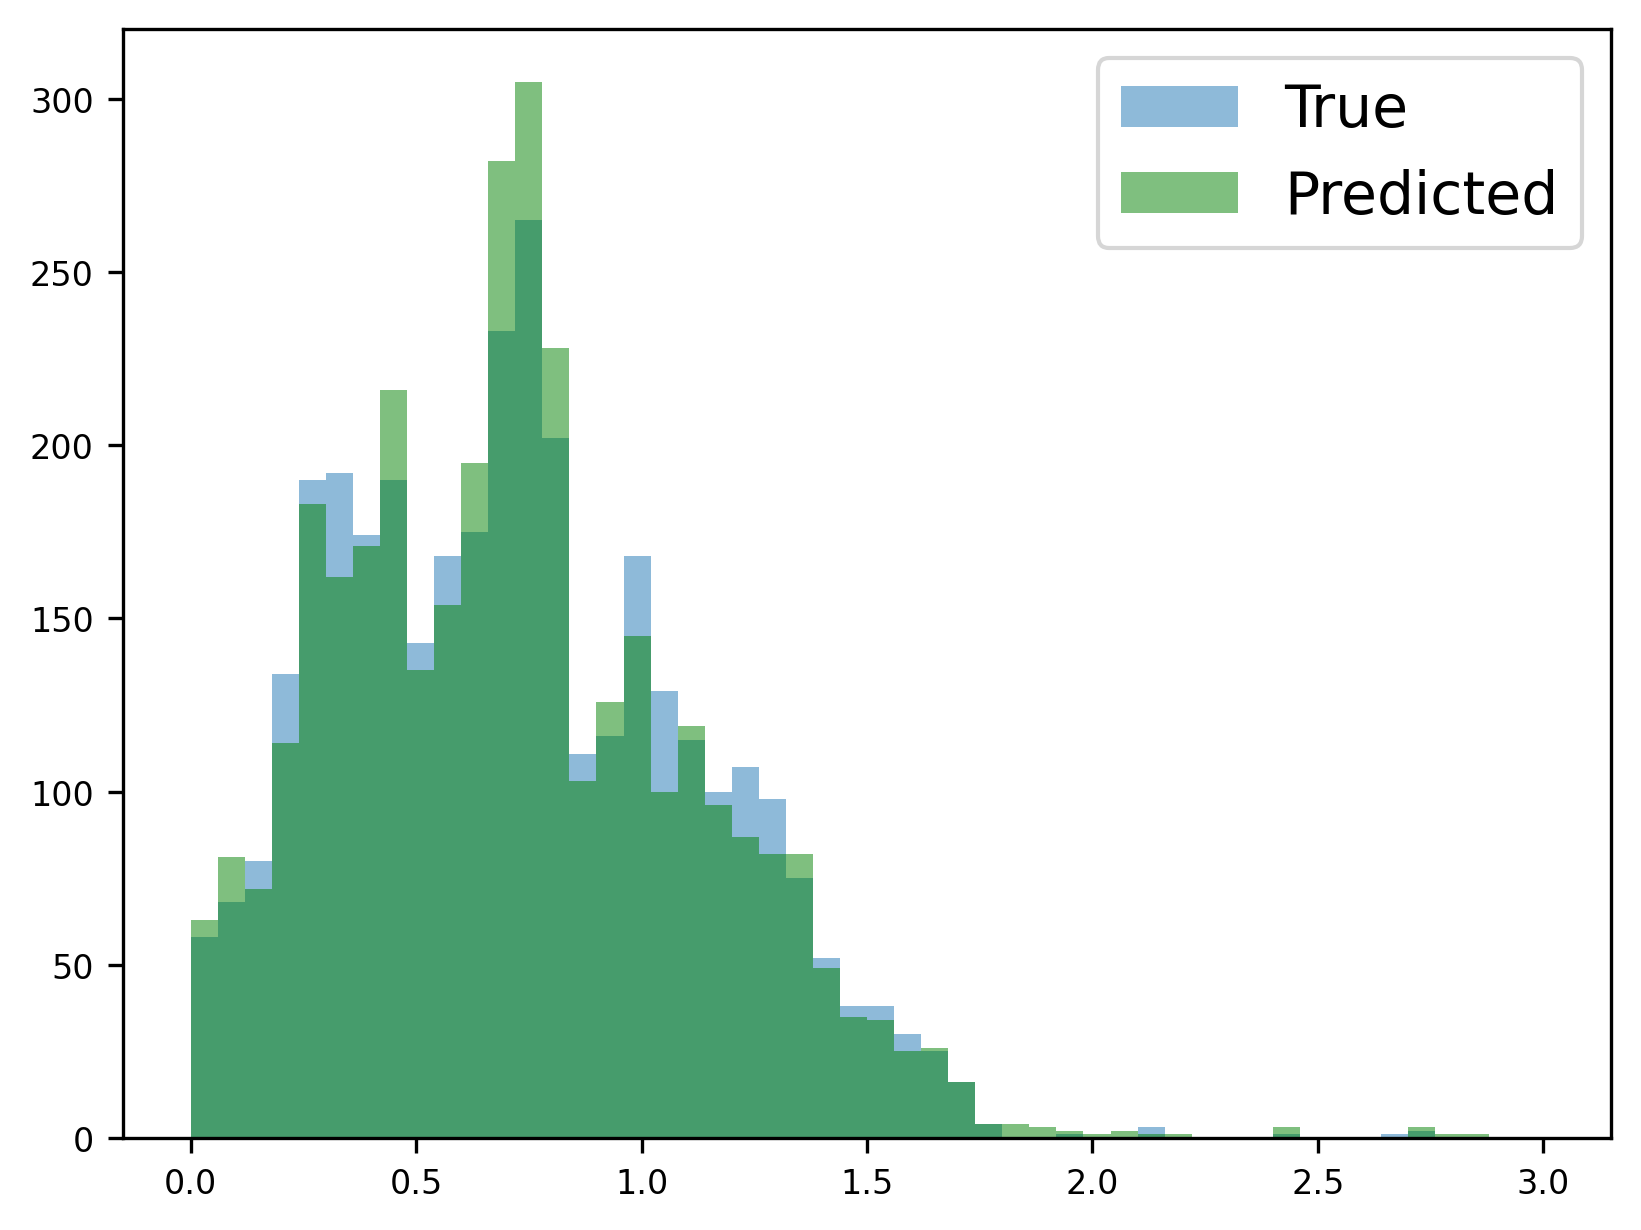

In [21]:
plt.hist(y_test,bins=50,density=False,alpha=0.5, range = (0,3), label = 'True');
plt.hist(y_predict,bins=50,density=False,alpha=0.5, range = (0,3), color = 'g', label = 'Predicted');
plt.legend(fontsize=14);

**To calculate NMAD and outlier fraction, maybe you need to flatten the arrays, see line below:**

In [22]:
y_test = np.array(y_test).flatten()  # Flatten if needed
y_predict = np.array(y_predict).flatten()  # Flatten if needed

In [23]:
print(y_test.size)
print(y_predict.size)

3574
3574


In [24]:
1.48*np.median(np.abs(y_test-y_predict)/(1 + y_test))


0.09988621397985725

In [25]:
len(np.where(np.abs(y_test-y_predict)>0.15*(1+y_test))[0])/len(y_test)

0.3240067151650811

**How does your result compares with the results in the paper?**

**Make a plot of Truth (test) and Prediction to check how they compare**

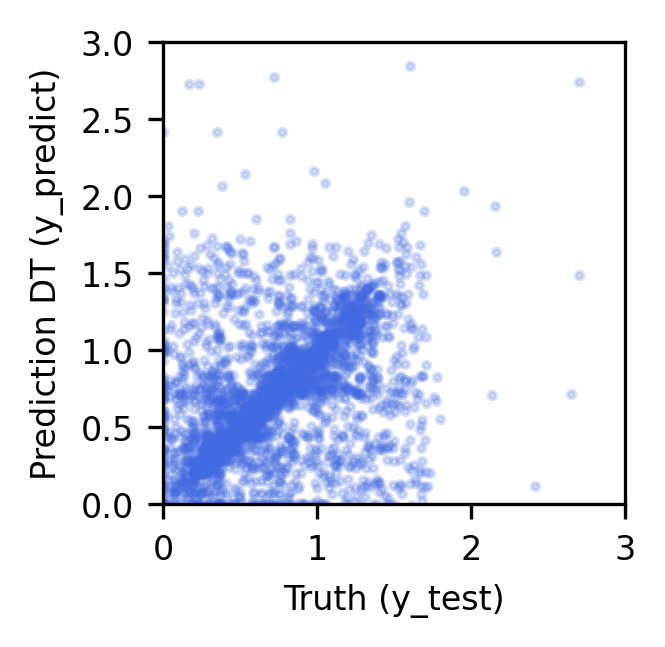

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.scatter(y_test, y_predict,  s = 3, alpha=0.2, c = 'royalblue')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)', fontsize=8)
ax.set_ylabel('Prediction DT (y_predict)', fontsize=8)
ax.set_aspect('equal')
plt.xlim(0,3)
plt.ylim(0,3)

plt.show()


**What do you think of your results?**

Not so good!


One way to improve the results of a model is to tune its parameters to run appropiately. In decision trees, this is particularly important, since an unleashed tree will try to fit all the train data, which can lead to overfitting.

Below is an implementation of [`RandomizedSearchCV`](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), which will randomly samples a specified number of parameter combinations from a given range and evaluates them using cross-validation to find the best-performing combination.
The advantage of this method over other optimization (such as [`GridSearchCV`](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GridSearchCV.html) is the computing time, which might be too long for larger datasets)

In [27]:
for key in DecisionTreeRegressor().get_params().keys():
    print(key)

ccp_alpha
criterion
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
monotonic_cst
random_state
splitter


In [28]:
hyperparameter_distributions = {
    'max_depth': np.arange(1, 20, 2).astype(int),
    'min_samples_split': np.arange(5, 105, 10).astype(int),
    'min_samples_leaf': np.arange(5, 105, 10).astype(int)
}

random_search = RandomizedSearchCV(
    dtree,
    param_distributions=hyperparameter_distributions,
    n_iter=100
)

random_search.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(estimator=DecisionTreeRegressor(), n_iter=100,
                   param_distributions={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_leaf': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95]),
                                        'min_samples_split': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95])})

The best results are

In [29]:
print(random_search.best_params_)


{'min_samples_split': 85, 'min_samples_leaf': 25, 'max_depth': 11}


**Now we can check whether the optimization of hyperparameters had any effect in the results. Plot again the comparison between test and prediction, and calculate the metrics and $\sigma_{NMAD}$ and the outlier fraction**

MSE = 0.1228


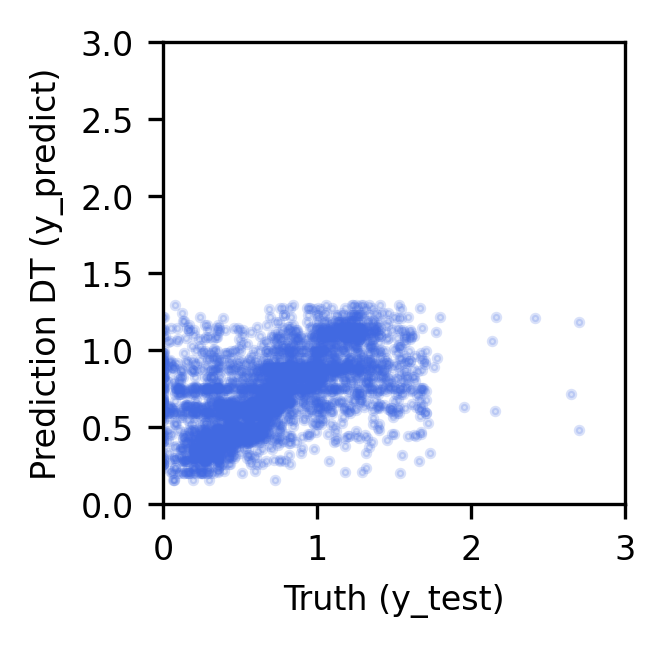

In [30]:
y_predict = random_search.predict(X_test) #fit the model with the best params
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.scatter(y_test, y_predict, s = 3, alpha=0.2, c = 'royalblue')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)', fontsize=8)
ax.set_ylabel('Prediction DT (y_predict)', fontsize=8)
ax.set_aspect('equal')
plt.xlim(0,3)
plt.ylim(0,3)
plt.show()

In [31]:
1.48*np.median(np.abs(y_test-y_predict)/(1 + y_test))


0.12339984538279035

In [32]:
len(np.where(np.abs(y_test-y_predict)>0.15*(1+y_test))[0])/len(y_test)

0.312534974818131

**Do you think there was an improvement?**

### Part 2 Random Forest
It is clear that Decision Trees are not very good predictors of redshift. We obtain a high fraction of outliers and certainly we can do better with MSE. So, to improve the metrics, we'll try a more complex approach, with **Random Forests**, which are tree-based supervised learning models.

We initialize the model [`RandomForestRegressor()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [33]:
model = RandomForestRegressor()

we can check the parameters of the model...notice that some of those are for each tree and others, for the forest (ensemble)

In [34]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Now, we will use cross validation to obtain the metrics with training and test data, and to get some diagnostics of the results. Below is the implementation, check the parameters of KFold and try to change it and see what you obtain. More information about cross validation, KFold and other methods in this [link](https://scikit-learn.org/1.5/modules/cross_validation.html).

The results are the metric scores (as default, it calculates $R^2$, but you can change this in Kfold with the `scoring` parameter of cross_validate (see sklearn documentation)

In [35]:
%%time
#it will take about 2 minutes
scores = cross_validate(model,features,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

CPU times: user 1min 21s, sys: 364 ms, total: 1min 21s
Wall time: 1min 28s


In [36]:
scores

{'fit_time': array([15.40639329, 15.25713515, 16.8056078 , 15.54602981, 21.79851031]),
 'score_time': array([0.15721035, 0.15791702, 0.16159511, 0.18483996, 0.16014338]),
 'test_score': array([0.29864717, 0.30972003, 0.31865402, 0.30817794, 0.31684727]),
 'train_score': array([0.87258695, 0.87905009, 0.87852096, 0.87755602, 0.87447377])}

In [37]:
np.mean(scores['test_score'])

0.31040928508897186

In [38]:
np.mean(scores['train_score'])

0.8764375596776233

How does the train score compares with the test score? What can you say about that?

Let's compare the true values with the predictions. When we run `cross_validate()` we only obtain the metric scores, if we want the predictions, we use `cross_val_predict()`

In [40]:
ypred = cross_val_predict(model,features,target, cv = KFold(n_splits=5, shuffle=True, random_state=10))

**Plot the comparison between prediction and true values for random forests**

(0.0, 3.0)

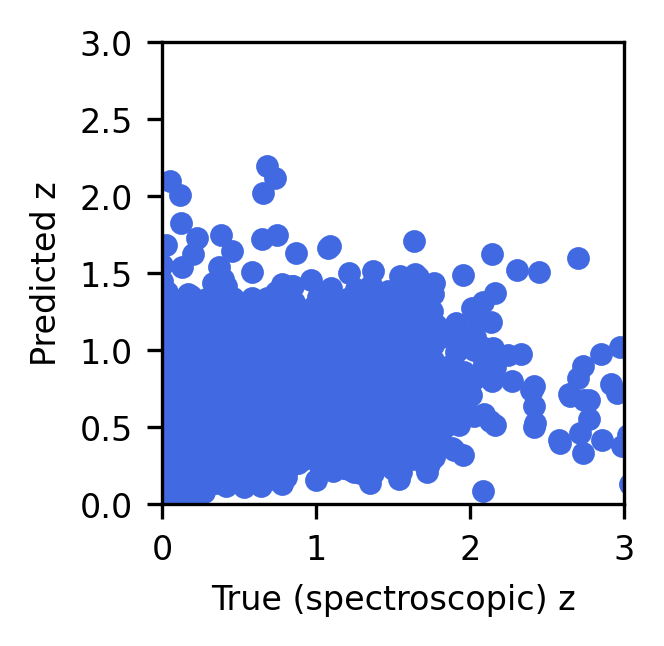

In [41]:
plt.figure(figsize=(2, 2))
plt.scatter(target,ypred, s = 20, c = 'royalblue')
plt.xlabel('True (spectroscopic) z', fontsize=8)
plt.ylabel('Predicted z',fontsize=8)
plt.axis('square')
plt.xlim(0,3)
plt.ylim(0,3)

**Also, check and compare the distribution of true and predicted redshifts (histogram)**

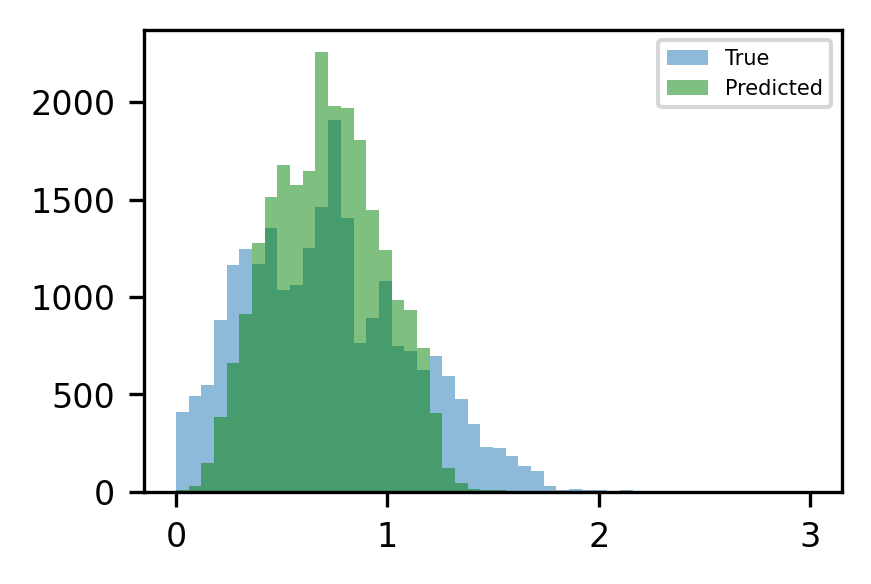

In [42]:
plt.figure(figsize=(3, 2))

plt.hist(target,bins=50,density=False,alpha=0.5, range = (0,3), label = 'True');
plt.hist(ypred,bins=50,density=False,alpha=0.5, range = (0,3), color = 'g', label = 'Predicted');
plt.legend(fontsize=5);

**Calculate the $\sigma_{NMAD}$ and outliers fraction and again, compare with the paper...**

In [43]:
len(np.where(np.abs(target-ypred)>0.15*(1+target))[0])/len(target)

0.2571992276047351

In [44]:
1.48*np.median(np.abs(target-ypred)/(1 + target))


0.07422316965365314

You probably notice that we are not doing so good. We have a **high variance**, then we are **overfitting**. This is typical for trees and forest, when are "unleashed". We can try to optimize the hyperparameters of the model. To save some time, we will select a random subsample of the data and optimize with it.

**Select a random subsample of the data (features and target)**

In [45]:
np.random.seed(20)
sel = np.random.choice(range(len(ypred)), 5000, replace = False) #sample sin reemplazo

In [46]:
len(np.unique(sel))

5000

In [47]:
seld = features.loc[sel,:]
selt = target[sel]

**It is good practice to ensure that the performance on the smaller set remains similar to the one obtained on the entire data set, which means that the change in size will not significantly affect the optimization process. Check the metrics with cross_validate and compare with the one obtained previously with random forest (our benchmark)**

In [48]:
littlescores = cross_validate(model,seld,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [49]:
littlescores['test_score'].mean(), littlescores['train_score'].mean()

(0.27762715338769406, 0.8763722031531694)

**If the metrics are similar as before, we can move on to the optimization of hyperparameters. As in the case of Decision trees, perform a `RandomizedSearchCV(). Check also the hyperparameters of RF, and decide which ones you want to use. More information of the parameters you can find [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)**


As as suggestion, use this grid

`
parameters = {
    'min_impurity_decrease': [0.1, 0.5, 0.0],
    'max_features': [None, 4, 2],
    'n_estimators': [50, 100, 200],
    'min_samples_split': [10, 20, 100],
    'max_leaf_nodes': [None, 100, 200]
}`


In [52]:
model.get_params()

{'cv': KFold(n_splits=5, random_state=None, shuffle=True),
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(),
 'n_iter': 50,
 'n_jobs': -1,
 'param_distributions': {'min_impurity_decrease': [0.1, 0.5, 0.0],
  'max_features': [None, 4, 2],
  'n_estimators': [50, 100, 200],
  'min_samples_split': [10, 20, 100],
  'max_leaf_nodes': [None, 100, 200]},
 'pre_dispatch': '2*n_jobs

In [51]:
parameters = {
    'min_impurity_decrease': [0.1, 0.5, 0.0],
    'max_features': [None, 4, 2],
    'n_estimators': [50, 100, 200],
    'min_samples_split': [10, 20, 100],
    'max_leaf_nodes': [None, 100, 200]
}

model = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions=parameters,
    n_iter=50,  # Number of random combinations to try
    cv=KFold(n_splits=5, shuffle=True),
    verbose=2,
    n_jobs=-1,
    random_state=42,  # Ensure reproducibility
    return_train_score=True
)

model.fit(seld, selt)
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params, best score: 0.2903 {'n_estimators': 50, 'min_samples_split': 10, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 2}


We can create a dataframe with the scores for each combination of parameters, sorted from the best models to the worst

In [53]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)


In [54]:
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
48,"{'n_estimators': 50, 'min_samples_split': 10, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 2}",0.290331,0.020713,7.204523e-01
24,"{'n_estimators': 200, 'min_samples_split': 20, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 2}",0.289072,0.016961,6.219968e-01
21,"{'n_estimators': 100, 'min_samples_split': 10, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None}",0.285377,0.019355,7.618515e-01
16,"{'n_estimators': 200, 'min_samples_split': 10, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 200, 'max_features': 2}",0.284333,0.016555,6.297582e-01
29,"{'n_estimators': 200, 'min_samples_split': 10, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 200, 'max_features': 4}",0.283370,0.019874,6.644981e-01
4,"{'n_estimators': 100, 'min_samples_split': 20, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 200, 'max_features': 2}",0.282418,0.015726,5.936647e-01
40,"{'n_estimators': 50, 'min_samples_split': 20, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 200, 'max_features': None}",0.279187,0.019401,6.353435e-01
34,"{'n_estimators': 50, 'min_samples_split': 10, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None}",0.274555,0.021403,7.605208e-01
27,"{'n_estimators': 100, 'min_samples_split': 10, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 200, 'max_features': None}",0.273117,0.019137,6.783823e-01
19,"{'n_estimators': 100, 'min_samples_split': 10, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_features': 4}",0.271649,0.016975,5.438157e-01


Did we obtain better results?

Probably you already notice that we have not improve the results. :(

### Part 3: A little of Feature engineering

Before giving up, and after noting that our issue is so severe that it's hard to attribute it to an optimization or chooice of algorithm issue, we need to look more carefully at data cleaning and/or imputing (something, in fact, that should be the first step in our pipeline!)


If you check the [paper](https://arxiv.org/pdf/1903.08174) (Table 6) you will notice that the authors consider many more columns that the ones we are using here. There are in particular some columns with information about the *quality* of the data provided. These columns are
- 'subaru_source':  source of the Y -band photometry: 0 = deep pointing; 1 = shallow pointing; -99 = not observed
- 'cfhtls_source': source of the ugri(i2)z photometry: 0 = Deep field; 1 = Wide field; -99 = not observed
- 'zquality':  (In DEEP2/3 catalog) DEEP2/3 redshift quality flag

**Create a dataframe with the columns we selected before and the three new ones mentioned above**

In [55]:
mags = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor','subaru_source','cfhtls_source','zquality']]


In [56]:
mags.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor,subaru_source,cfhtls_source,zquality
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356,1,1,2
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085,1,1,4
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000,-99,1,1
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600,1,1,1
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980,1,1,4


In [57]:
mags.shape

(23822, 9)

**So, we need to filter the data based on quality. Filter your data with these criterias:**

- **redshift quality: only use objects with high-quality spectroscopic redshift measurements 'zquality' >= 3**
- **select objects with cfhtls deep photometric data ('cfhtls_source' == 0)**
- **select objects with subaru deep photometry ('subaru_source' == 0)**
- **Also, unavailable measurements are marked by -99 or 99 (while typical values are around 20-25). We also get rid of data with missing measurements.**


In [58]:
#zquality - solo usa objetos con medición de redshift de buena calidad

mags = mags[mags['zquality'] >= 3]

mags.shape

(16857, 9)

In [59]:
#selecciona objetos con datos del catálogo cfhtls deep photometric data

mags = mags[mags['cfhtls_source'] == 0]

mags.shape

(10671, 9)

In [60]:
mags = mags[mags > -10].dropna()

In [61]:
mags.shape

(6371, 9)

In [62]:
mags = mags[mags < 90].dropna()

In [63]:
mags

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor,subaru_source,cfhtls_source,zquality
1251,24.244393,23.979583,23.522136,22.911041,22.525773,22.329098,1.0,0,4
1253,24.489104,23.916151,22.923651,21.873752,21.306495,21.251440,1.0,0,4
1261,24.873959,22.973893,21.465850,20.788420,20.462283,20.413696,1.0,0,3
1271,24.529042,24.338631,23.891189,23.206102,22.989344,23.112382,1.0,0,4
1272,23.641180,23.387447,22.975301,22.235199,21.809658,21.559483,1.0,0,4
...,...,...,...,...,...,...,...,...,...
19949,24.455093,24.275983,24.233811,24.109624,23.809521,23.389464,0.0,0,4
20131,23.461026,23.007713,22.359102,21.553143,20.946282,20.972074,0.0,0,3
20134,24.615031,22.985132,21.601458,21.027322,20.732666,20.588093,0.0,0,4
20135,22.611269,22.080842,21.404755,21.188319,20.962956,20.998884,0.0,0,4


In [64]:
sel_features = mags[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]
sel_features.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
1251,24.244393,23.979583,23.522136,22.911041,22.525773,22.329098
1253,24.489104,23.916151,22.923651,21.873752,21.306495,21.251440
1261,24.873959,22.973893,21.465850,20.788420,20.462283,20.413696
1271,24.529042,24.338631,23.891189,23.206102,22.989344,23.112382
1272,23.641180,23.387447,22.975301,22.235199,21.809658,21.559483


**Of course, remember to select from the target array the corresponding rows from your selections above**

In [65]:
sel_target = target[sel_features.index]

**Now, repeat the cross_validate() process with RandomForestRegressor (you can copy the code above) but using the selected data and obtain the metrics**

In [66]:
scores = cross_validate(RandomForestRegressor(random_state = 5),sel_features,sel_target,cv = KFold(n_splits=5, shuffle=True, random_state=10), \
               return_train_score=True)

In [67]:
print(np.round(np.mean(scores['test_score']),3), np.round(np.std(scores['test_score']),3))

0.746 0.106


In [68]:
print(np.round(np.mean(scores['train_score']),3), np.round(np.std(scores['train_score']),3))

0.963 0.005


**You can try to optimized the hyperparameters again to improve the results**

In [69]:
parameters = {
    'max_depth': [3, 6, None],
    'max_features': [None, 4, 2],
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [1, 5, 10]
}

# Calculate the number of models in a grid search
nmodels = np.product([len(el) for el in parameters.values()])
print(f"Number of models in GridSearch: {nmodels}")

# Use RandomizedSearchCV instead of GridSearchCV
model = RandomizedSearchCV(
    RandomForestRegressor(random_state=5),
    param_distributions=parameters,
    n_iter=30,  # Number of random combinations to evaluate
    cv=KFold(n_splits=5, shuffle=True, random_state=10),
    verbose=2,
    n_jobs=4,
    random_state=42,  # Ensures reproducibility
    return_train_score=True
)

# Fit the model
model.fit(sel_features, sel_target)

# Print the best parameters and score
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_)


Number of models in GridSearch: 81
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params, best score: 0.7465 {'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}


In [70]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
18,"{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}",0.746483,0.105639,0.963281
21,"{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 4, 'max_depth': None}",0.745839,0.096776,0.963471
16,"{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 2, 'max_depth': None}",0.741378,0.095392,0.962657
27,"{'n_estimators': 50, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}",0.740724,0.109204,0.962312
14,"{'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 4, 'max_depth': None}",0.738346,0.100682,0.853271
12,"{'n_estimators': 100, 'min_samples_leaf': 5, 'max_features': 4, 'max_depth': None}",0.736813,0.101096,0.852644
25,"{'n_estimators': 200, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': None}",0.723692,0.103387,0.810218
17,"{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': None}",0.722848,0.103613,0.809593
7,"{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 4, 'max_depth': None}",0.719392,0.097459,0.801651
13,"{'n_estimators': 200, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 6}",0.627287,0.087923,0.683383


In [71]:
bm = model.best_estimator_

In [72]:
bm

RandomForestRegressor(max_features=None, random_state=5)

In [73]:
ypred = cross_val_predict(bm, sel_features,sel_target, cv = KFold(n_splits=5, shuffle=True, random_state=10))

Re plot the comparison between true and predicted values and calculate the outlier fraction and $\sigma_{NMAD}$ and compare them to the paper

(0.0, 2.0)

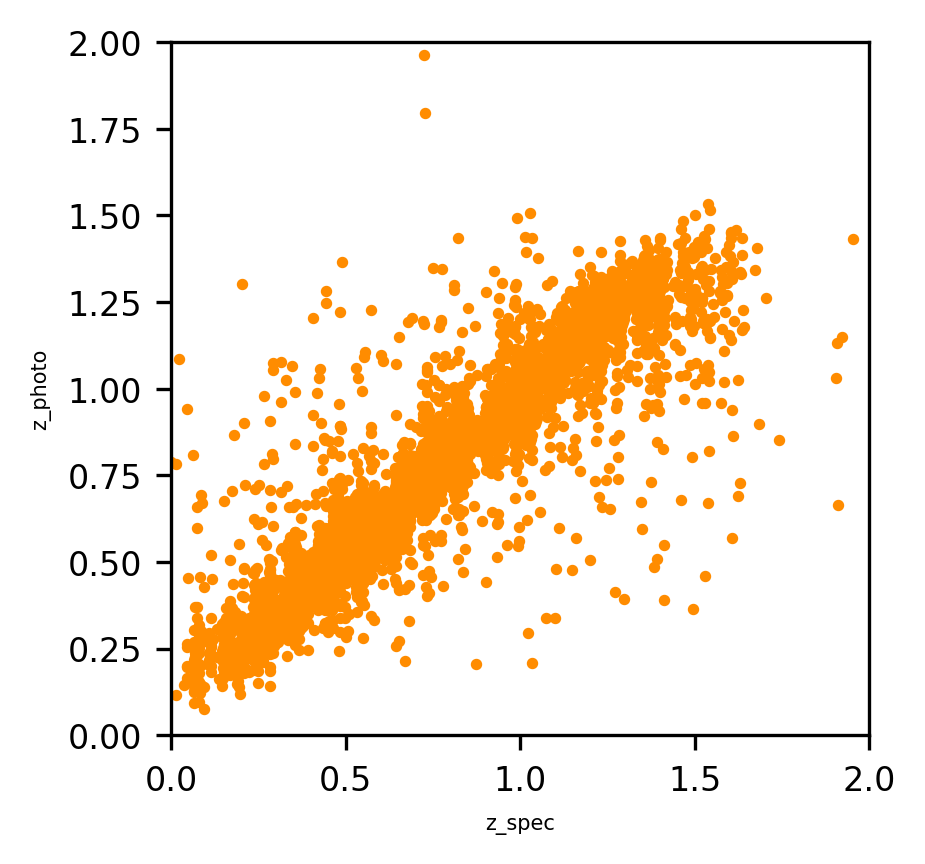

In [ ]:
plt.figure(figsize=(3,3))
plt.scatter(sel_target,ypred, s =3, color='darkorange')
plt.xlabel('z_spec', fontsize=5)
plt.ylabel('z_photo', fontsize=5)
plt.ylim(0,2)
plt.xlim(0,2)

In [ ]:
len(np.where(np.abs(sel_target-ypred)>0.15*(1+sel_target))[0])/len(sel_target)

0.054542571745679405

In [ ]:
1.48*np.median(np.abs(sel_target-ypred)/(1 + sel_target))

0.03607171556040228

**So, what do you think? did it improve the result??**

**In any case, the lesson here is that with a simple improvement in the data (selecting by data quality) we improve much more the model than only optimizing the hyperparameters. That's the reason why is so important to explore and understand the data!**

### Part 4: Let's go neural!

We now will use  a fully connected neural network to solve the problem. With RF we already obtain a very good result, but let's see if we can improve it substantially with a more complex sophisticated model, such as NN

In [74]:
import tensorflow as tf

In [75]:
import keras

from keras.models import Sequential #the model is built adding layers one after the other

from keras.layers import Dense #fully connected layers: every output talks to every input

from keras.layers import Dropout #for regularization

WE will make a copy of the sel_features and sel_targets to name them X and y respectively. We will use the better quality selection of the whole data

In [76]:
X=sel_features.copy()
y=sel_target.copy()

We will split the data in train/validation/test. First we will shuffle them

In [77]:
X,y = shuffle(X,y, random_state = 12)

In [ ]:
fifth = int(len(y)/5) #Divide data in fifths to use 60/20/20 split

In [ ]:
X_train = X.values[:3*fifth,:]
y_train = y[:3*fifth]

X_val = X.values[3*fifth:4*fifth,:]
y_val = y[3*fifth:4*fifth]

X_test = X.values[4*fifth:,:]
y_test = y[4*fifth:]

 we need to scale our data! NNs use matrix operations with weights and biases to compute activations. These involve multiplying input features by weights and passing them through activation functions like ReLU or sigmoid. Large values of the features may affect these operations, affect the convergence of the NN and avoid a bias towards features with highr values



In [ ]:
scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler()

In [ ]:
Xst_train = scaler.transform(X_train)
Xst_val = scaler.transform(X_val)
Xst_test = scaler.transform(X_test)

**In a regression problem, we will choose a different activation for the output layer (e.g. linear), and an appropriate loss function (MSE, MAE, ...).**

**Our input layer has six neurons for this problem.**

**For other parameters and the network structure, we can start with two layers with 100 neurons and go from there.**

**Try to implement the NN (Sequential) with the architecture described. if you get loss, see the solution ;). As optimizer use Adam, and the activation function for intermediate layers, use RELU**

In [ ]:
model = Sequential()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Add an input layer and specify its size (number of original features)

model.add(Dense(100, activation='relu', input_shape=(6,)))

# Add one hidden layer and specify its size

model.add(Dense(100, activation='relu'))

# Add an output layer

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer=optimizer)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Implement the NN with  100 epochs and batch size = 300.**

In [ ]:
mynet = model.fit(Xst_train, y_train, validation_data= (Xst_val, y_val), epochs=100, batch_size=300)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.4899 - val_loss: 0.2174
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2146 - val_loss: 0.1214
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1049 - val_loss: 0.0621
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0599 - val_loss: 0.0411
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0465 - val_loss: 0.0338
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0413 - val_loss: 0.0325
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0397 - val_loss: 0.0300
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0433 - val_loss: 0.0300
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0357 - val_loss: 0.0289
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0400 - val_loss: 0.0288
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0378 - val_loss: 0.0279
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [ ]:
results = model.evaluate(Xst_test, y_test)
print('MSE:', results) #we are only monitoring the MSE

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0380
MSE: 0.028980104252696037


**Plot the loss throughout the training process.**

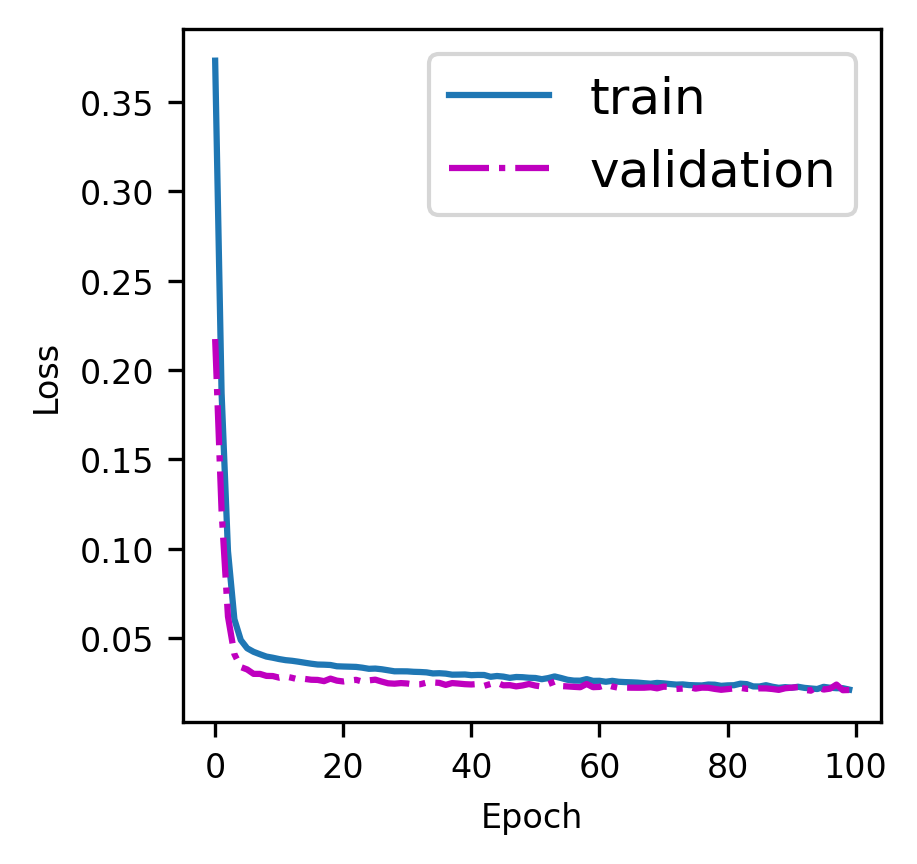

In [ ]:
plt.figure(figsize=(3,3))

plt.plot(mynet.history['loss'], label = 'train')
plt.plot(mynet.history['val_loss'],'-.m', label = 'validation')
plt.ylabel('Loss', fontsize = 8)
plt.xlabel('Epoch', fontsize = 8)
plt.legend(loc='upper right', fontsize = 8)
plt.legend(fontsize = 12);


**As always with regression problems, it is helpful to plot the predictions against the true values.**


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


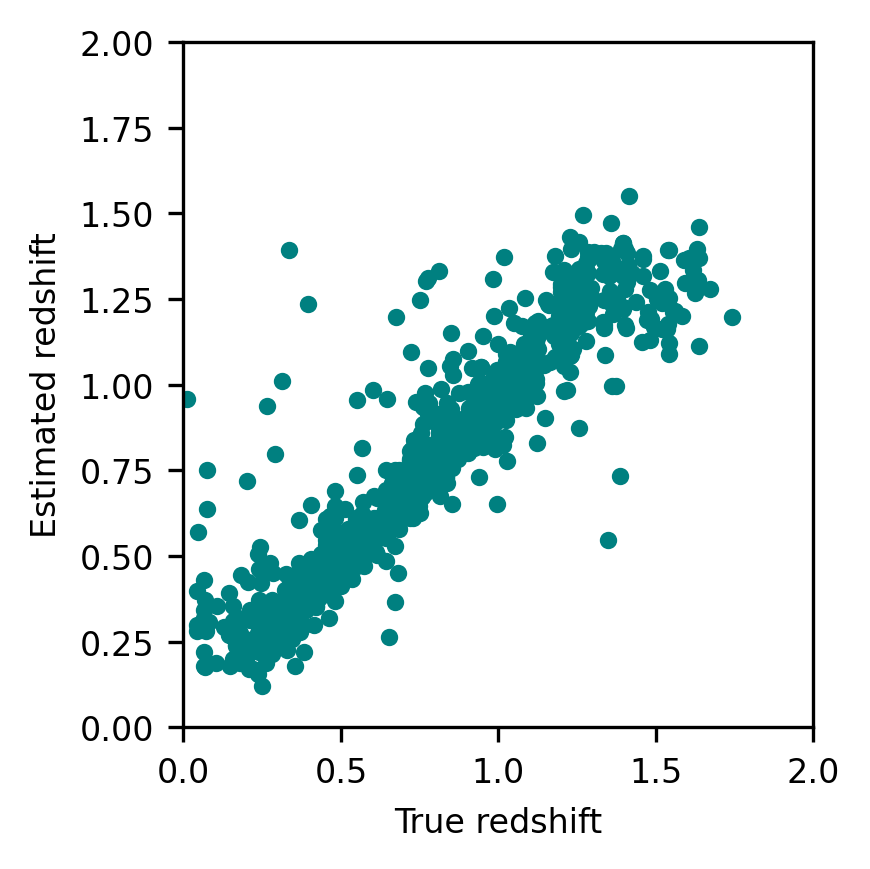

In [ ]:
plt.figure(figsize=(3,3))

plt.xlabel('True redshift', fontsize = 8)
plt.ylabel('Estimated redshift', fontsize = 8)

plt.scatter(y_test, model.predict(Xst_test), s =10, c = 'teal');

plt.xlim(0,2)
plt.ylim(0,2)
plt.tight_layout()
#plt.savefig('Photoz_NN_scatter.png')

**We didn't do cross validation, so generate prediction on our single test fold in order to derive the other metrics we are interested in (OLF and NMAD).**

In [ ]:
ypred = model.predict(Xst_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


**Calculate Outlier Fraction**

In [ ]:
y_test = np.array(y_test).flatten()  # Flatten if needed
ypred = np.array(ypred).flatten()  # Flatten if needed

In [ ]:
len(np.where(np.abs(y_test-ypred)>0.15*(1+y_test))[0])/len(y_test)

0.04829770387965162

**Calculate Normalized Median Absolute Deviation (NMAD)**

In [ ]:
1.48*np.median(np.abs(y_test-ypred)/(1 + y_test))

0.036753519922494884

**So What was best? RF o NNs?**

**Ok, this was a long exercise... What are your conclusions ??**

### Appendix: Optimization of parameters with Keras (optional)

Below is implemented optimization with Keras tuner. It takes a long time! you can follow the cells to see hoy it works ;)

### Let's try some optimization with keras tuner

In [ ]:
 !pip3 install keras-tuner --upgrade    #You may have to install keras tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import layers

#Some material below is adapted from the Keras Tuner documentation

# https://keras-team.github.io/keras-tuner/

This function specifies which parameters we want to tune. Tunable parameters can be of type "Choice" (we specify a set), Int, Boolean, or Float.

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 6)): #We try between 2 and 6 layers
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=100, #Each of them has 100-300 neurons, in intervals of 100
                                            max_value=300,
                                            step=100),
                               activation='relu'))
    model.add(Dense(1, activation='linear')) #last one
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), #And a few learning rates
        loss='mse')
    return model

Next, we specify how we want to explore the parameter space. The Random Search is the simplest choice, but often quite effective; alternatives are Hyperband (optimized Random Search where a larger fraction of models is trained for a smaller number of epochs, but only the most promising ones survive), or Bayesian Optimization, which attempts to build a probabilistic interpretation of the model scores (the posterior probability of obtaining score x, given the values of hyperparameters).

In [ ]:
tf.keras.backend.clear_session()

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=40, #number of combinations to try
    executions_per_trial=3,
    project_name='My Drive/Photoz') #may need to delete or reset

We can visualize the search space below:

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 300, 'step': 100, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 300, 'step': 100, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Finally, it's time to put our tuner to work. (This is a big job!)

In [ ]:
tuner.search(Xst_train, y_train, #same signature as model.fit
             epochs=100, validation_data=(Xst_val, y_val), batch_size=300, verbose = 1)

#Note: setting verbosity to 0 would give no output until done - it took about ~35 mins on my laptop

Trial 7 Complete [00h 00m 49s]
val_loss: 0.024510520820816357

Best val_loss So Far: 0.018194522708654404
Total elapsed time: 00h 05m 25s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
5                 |3                 |num_layers
200               |300               |units_0
100               |300               |units_1
0.01              |0.001             |learning_rate
200               |300               |units_2
100               |300               |units_3

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - loss: 0.5644 - val_loss: 0.1109
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0905 - val_loss: 0.0561
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0573 - val_loss: 0.0353
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0471 - val_loss: 0.0361
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0454 - val_loss: 0.0351
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0517 - v

KeyboardInterrupt: 

The "results\_summary(n)" function gives us access to the n best models. It's useful to look at a few because often the differences are minimal, and a smaller model might be preferable! Note that the "number of units" parameter would have a value assigned to it for each layers (even if the number of layers is smaller in that particular realization).

In [ ]:
tuner.results_summary(6)

Results summary
Results in ./My Drive/Photoz
Showing 6 best trials
Objective(name="val_loss", direction="min")

Trial 20 summary
Hyperparameters:
num_layers: 3
units_0: 300
units_1: 200
learning_rate: 0.01
units_2: 100
units_3: 300
units_4: 200
units_5: 200
Score: 0.01453858179350694

Trial 07 summary
Hyperparameters:
num_layers: 4
units_0: 100
units_1: 200
learning_rate: 0.01
units_2: 100
units_3: 300
units_4: 200
units_5: 200
Score: 0.01634461060166359

Trial 00 summary
Hyperparameters:
num_layers: 6
units_0: 100
units_1: 100
learning_rate: 0.001
units_2: 100
units_3: 100
units_4: 100
units_5: 100
Score: 0.01731111543873946

Trial 32 summary
Hyperparameters:
num_layers: 4
units_0: 100
units_1: 100
learning_rate: 0.01
units_2: 100
units_3: 300
units_4: 200
units_5: 100
Score: 0.01731827047963937

Trial 27 summary
Hyperparameters:
num_layers: 4
units_0: 300
units_1: 100
learning_rate: 0.01
units_2: 100
units_3: 200
units_4: 300
units_5: 100
Score: 0.017400021354357403

Trial 04 summary

The losses of the first few models are very similar, suggesting that 1. as usual, we need to do some form of cross-validation to be able to come up with a ranking, and 2. With 3-5 layers and a few hundred neurons per layer, the exact configuration doesn't matter too much.

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0] #choose first model

In [ ]:
best_hps.get('learning_rate')

0.01

In [ ]:
best_hps.get('num_layers')

3

In [ ]:
#Size of layers

print(best_hps.get('units_0'))
print(best_hps.get('units_1'))
print(best_hps.get('units_2'))

300
200
100


In [ ]:
model = tuner.hypermodel.build(best_hps) #define model = best model

In [ ]:
model.build(input_shape=(None,6)) #build best model (if not fit yet, this will give access to summary)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               2100      
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 82,501
Trainable params: 82,501
Non-trainable params: 0
_________________________________________________________________


Now, build a neural net with the optimal hyperparameters.

In [ ]:
bestnet = model.fit(Xst_train, y_train, validation_data= (Xst_val, y_val), epochs=100, batch_size=300)

Epoch 1/100
13/13 [==============================] - 3s 17ms/step - loss: 0.9970 - val_loss: 0.2567
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1649 - val_loss: 0.0822
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0796 - val_loss: 0.0452
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0533 - val_loss: 0.0347
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0483 - val_loss: 0.0334
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0450 - val_loss: 0.0309
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0428 - val_loss: 0.0287
Epoch 8/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0411 - val_loss: 0.0291
Epoch 9/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0407 - val_loss: 0.0297
Epoch 10/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0402 - val_loss: 0.0269
Epoch 11

We can also look at the train vs validation curves for the optimal model found by the tuner.

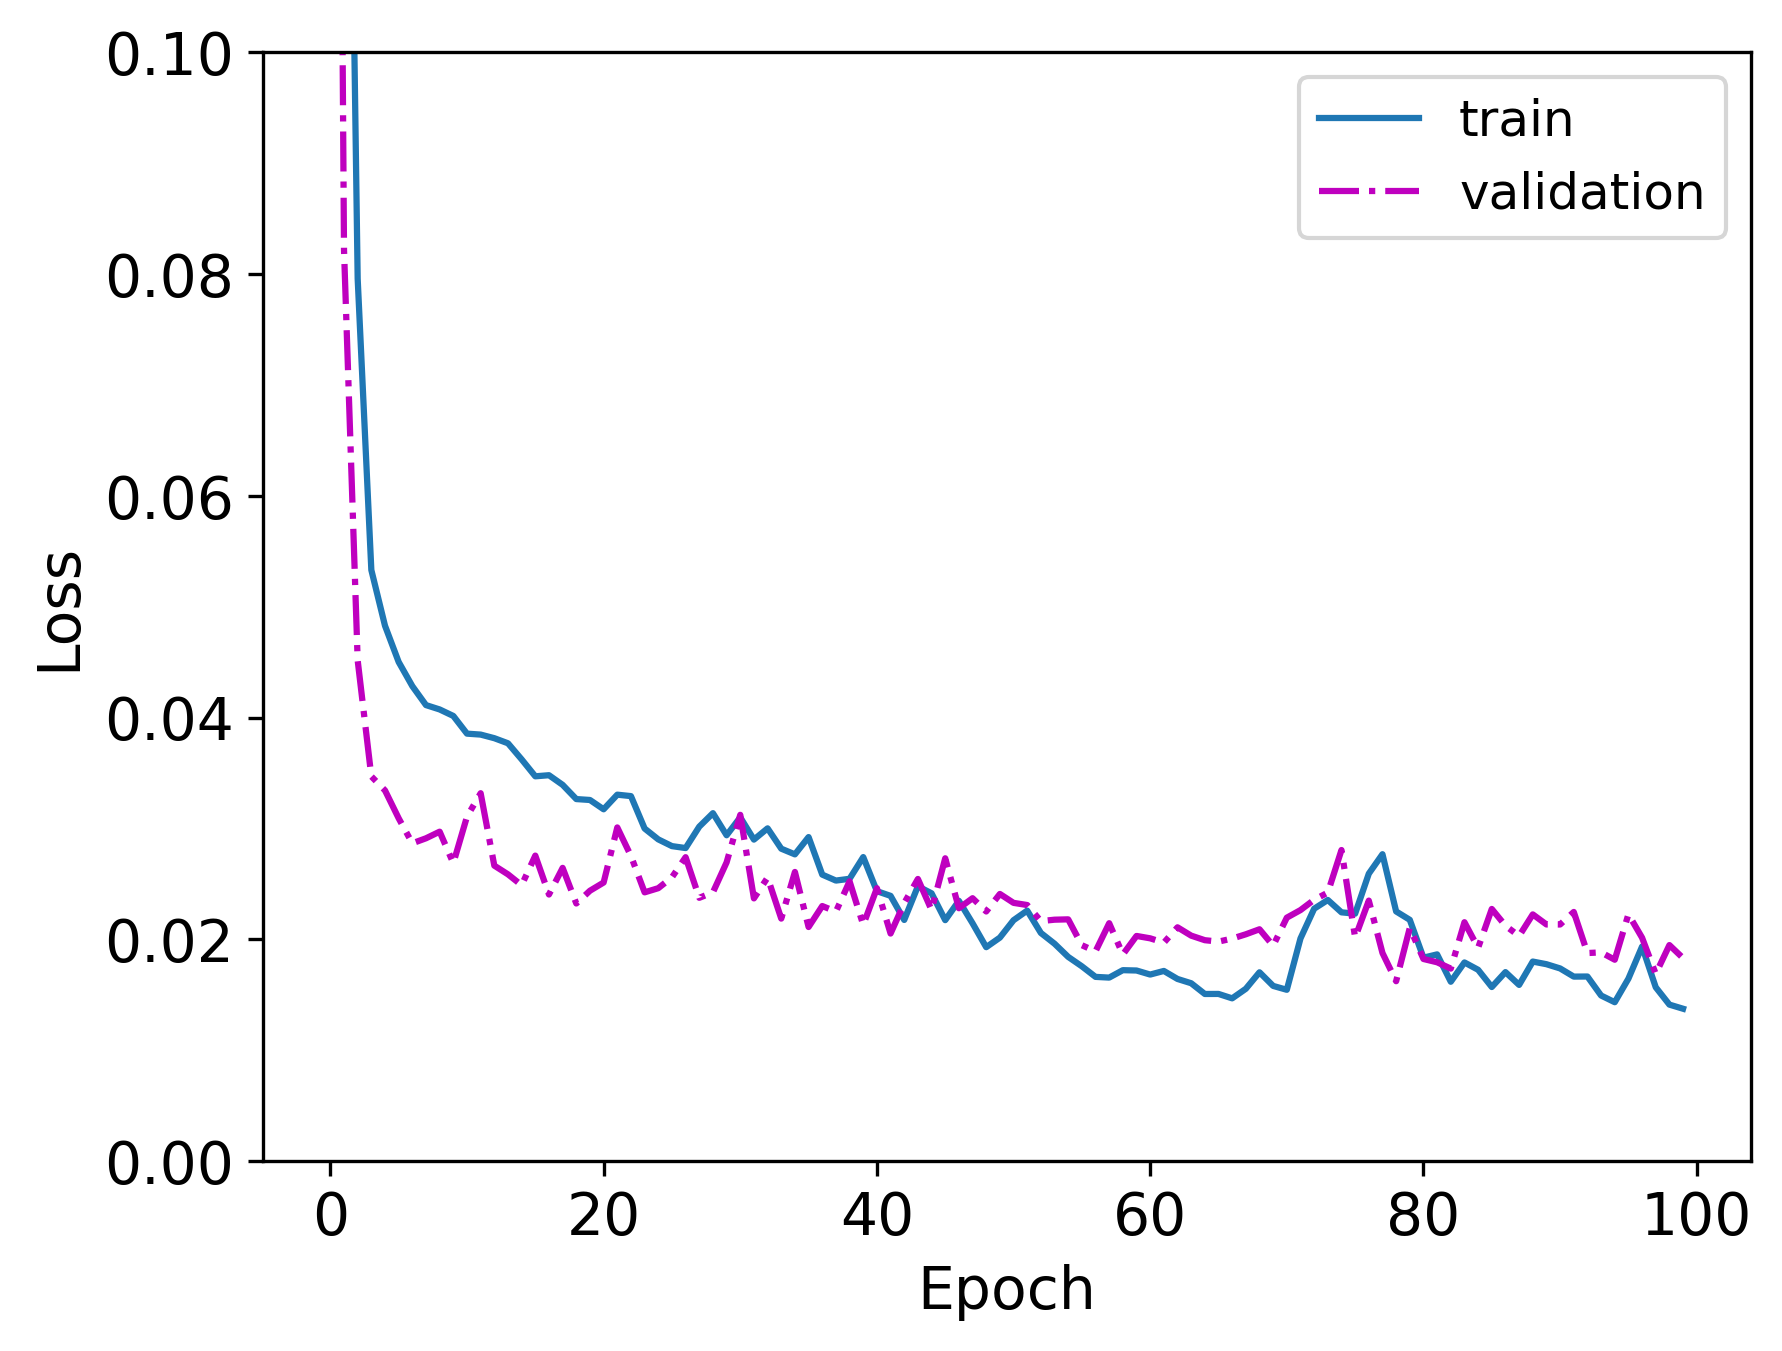

In [ ]:
plt.plot(bestnet.history['loss'], label = 'train')
plt.plot(bestnet.history['val_loss'],'-.m', label = 'validation')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.ylim(0,0.1)
plt.legend(loc='upper right', fontsize = 12)
plt.legend(fontsize = 12);
#plt.savefig('OptimalNN_Photoz.png',dpi=300)

Finally, we report test scores for all the metrics of interest (MSE, OLF, NMAD):

In [ ]:
model.evaluate(Xst_test, y_test)

40/40 [==============================] - 0s 2ms/step - loss: 0.0278


0.027751941233873367

In [ ]:
ypred = model.predict(Xst_test)

#Calculate OLF

print('OLF', len(np.where(np.abs(y_test-ypred)>0.15*(1+y_test))[0])/len(y_test))

#Calculate Normalized Median Absolute Deviation (NMAD)

print('NMAD', 1.48*np.median(np.abs(y_test-ypred)/(1 + y_test)))

40/40 [==============================] - 0s 3ms/step
OLF 0.030087094220110848
NMAD 0.032980624735051735


These numbers have somewhat improved, compared to the baseline model; note that whether improvement is significant should be determined via cross validation.